# <font color='blue'> Table Of Contents </font>

### <font color='blue'> AWS Sagemaker : Instance creation </font>

### <font color='blue'> HeartRate Data example : Problem Statement </font>

### <font color='blue'> HeartRate Data example : Sample data creation </font>

### <font color='blue'> HeartRate Data example : Solution </font>


In this week's notebook, we are going to explore batch procssing using pyspark. 

The platform that we are going to use for batch processing is AWS Sagemaker. 

We will create a notebook within AWS sagemaker where we will use pyspark to create aggregate data, partitions and moving average of the collected data. 

Spark deployments generally need to bring in multiple users, different types of jobs, etc, and we want to have these built-in. 

# <font color='blue'> Notebook role creation </font>
We will be creating an IAM role that we require to complete this lab.

To create a new role follow these steps-

1. On AWS console search for `IAM` service and click on `Roles` option.

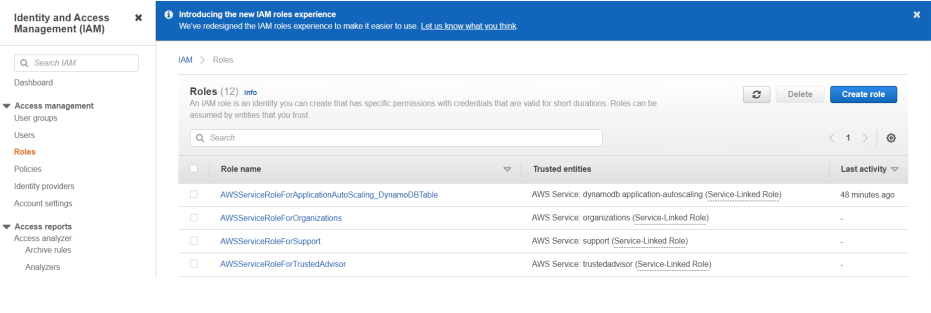
    
2. Click on `Create role`, you will get a screen as follows-

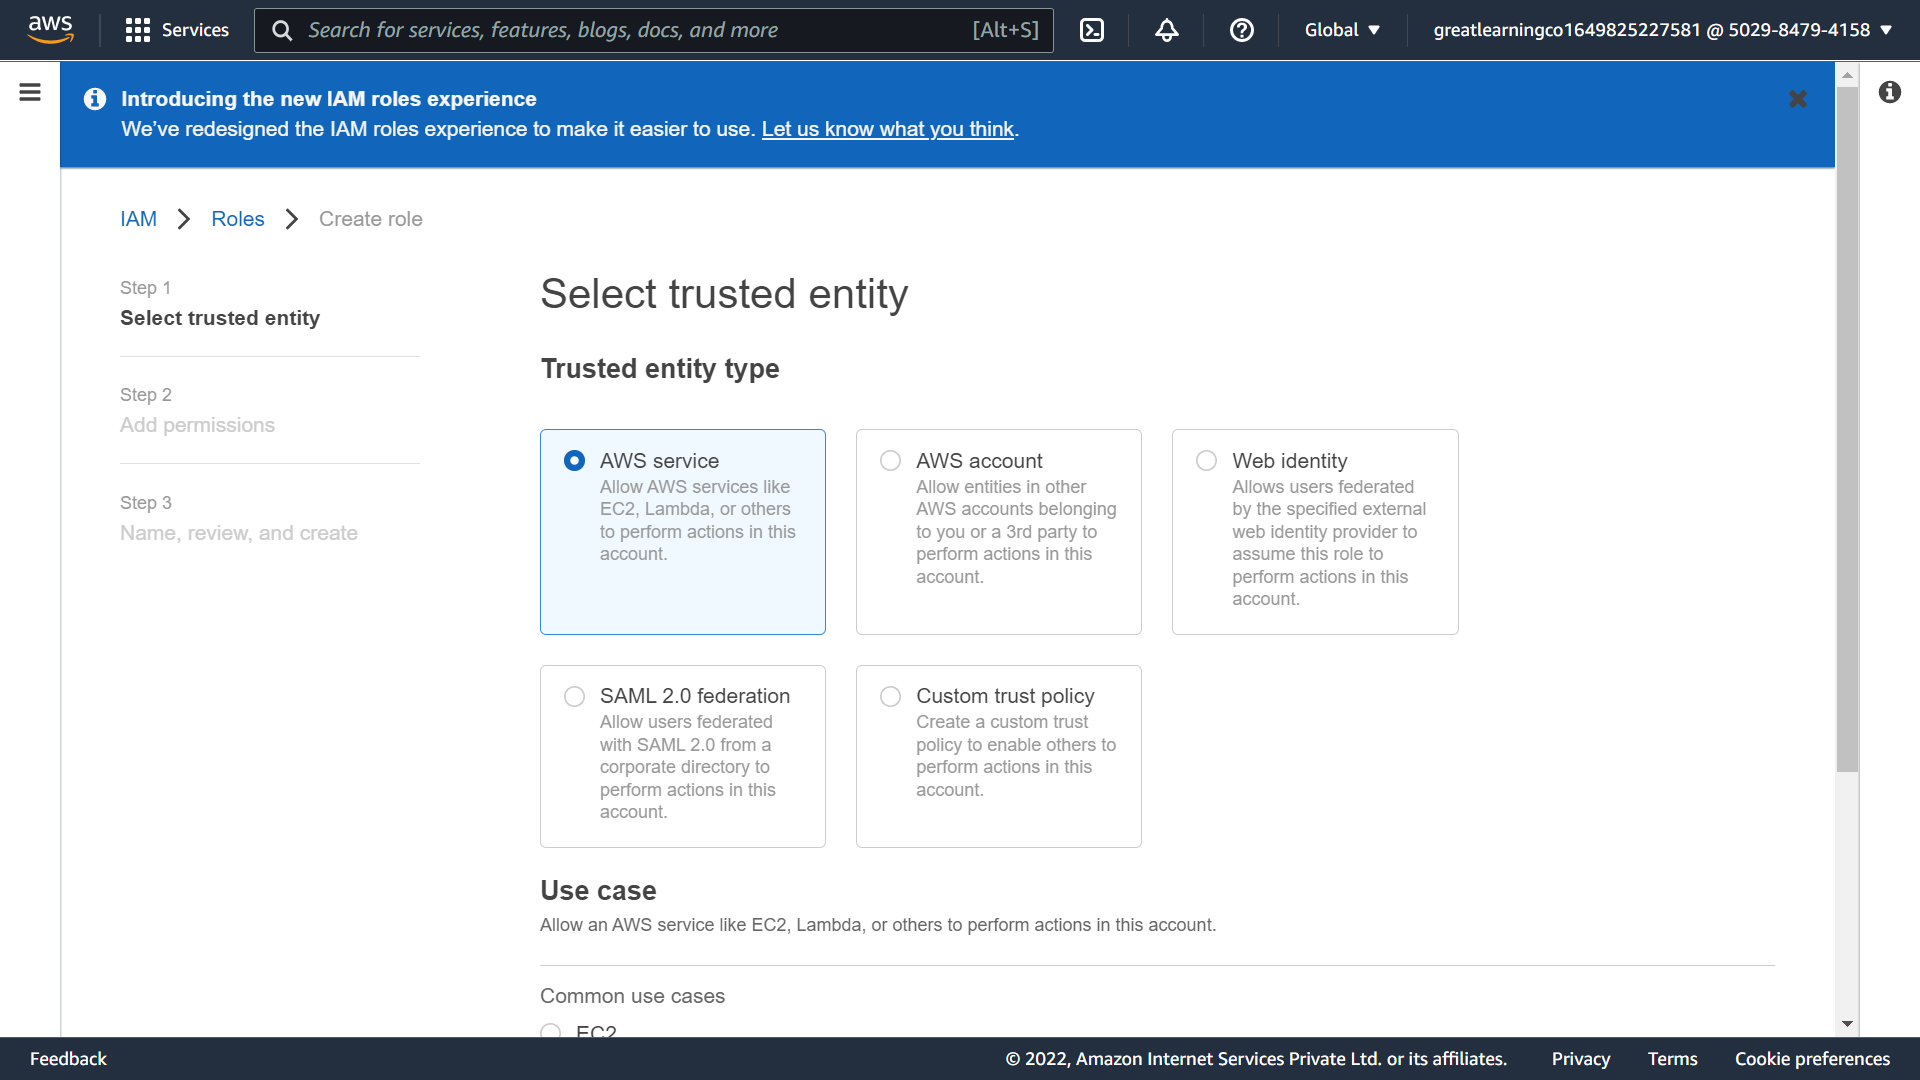

3. Scroll down to choose `Sagemaker` as the Use Case. Click `Next` and you will get the screen for Permission Policies. Make sure `AmazonSageMakerFullAccess` policy is added. Click `Next` again.

4. Give the Role name and click on `Create role`. On successful creation you can see the role name list in the roles list.

# <font color='blue'> AWS Sagemaker : Instance creation </font>

Lets create the Instance for our task on AWS sagemaker. 

Search for Sagemaker service on AWS and choose it. 

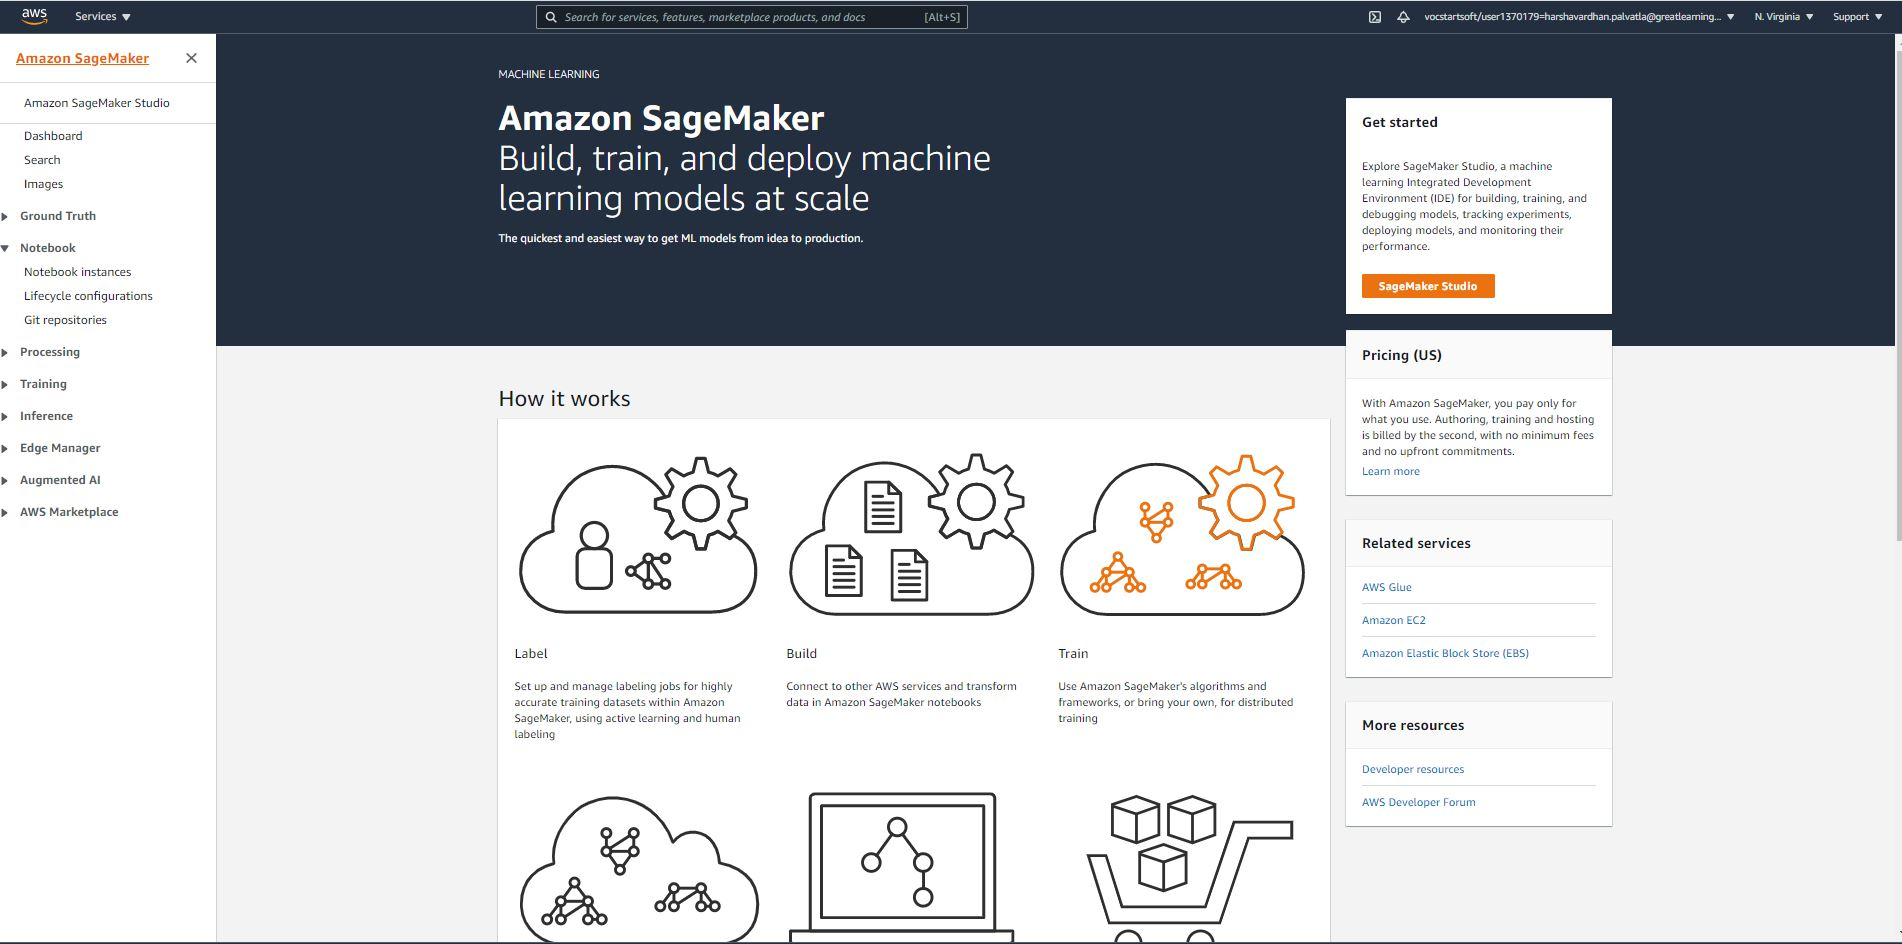

Click on `notebook` option available in the left pane. In the drop down choose Notebook instances as shown in the above image. 

On the next page click on `Create notebook instance`. 

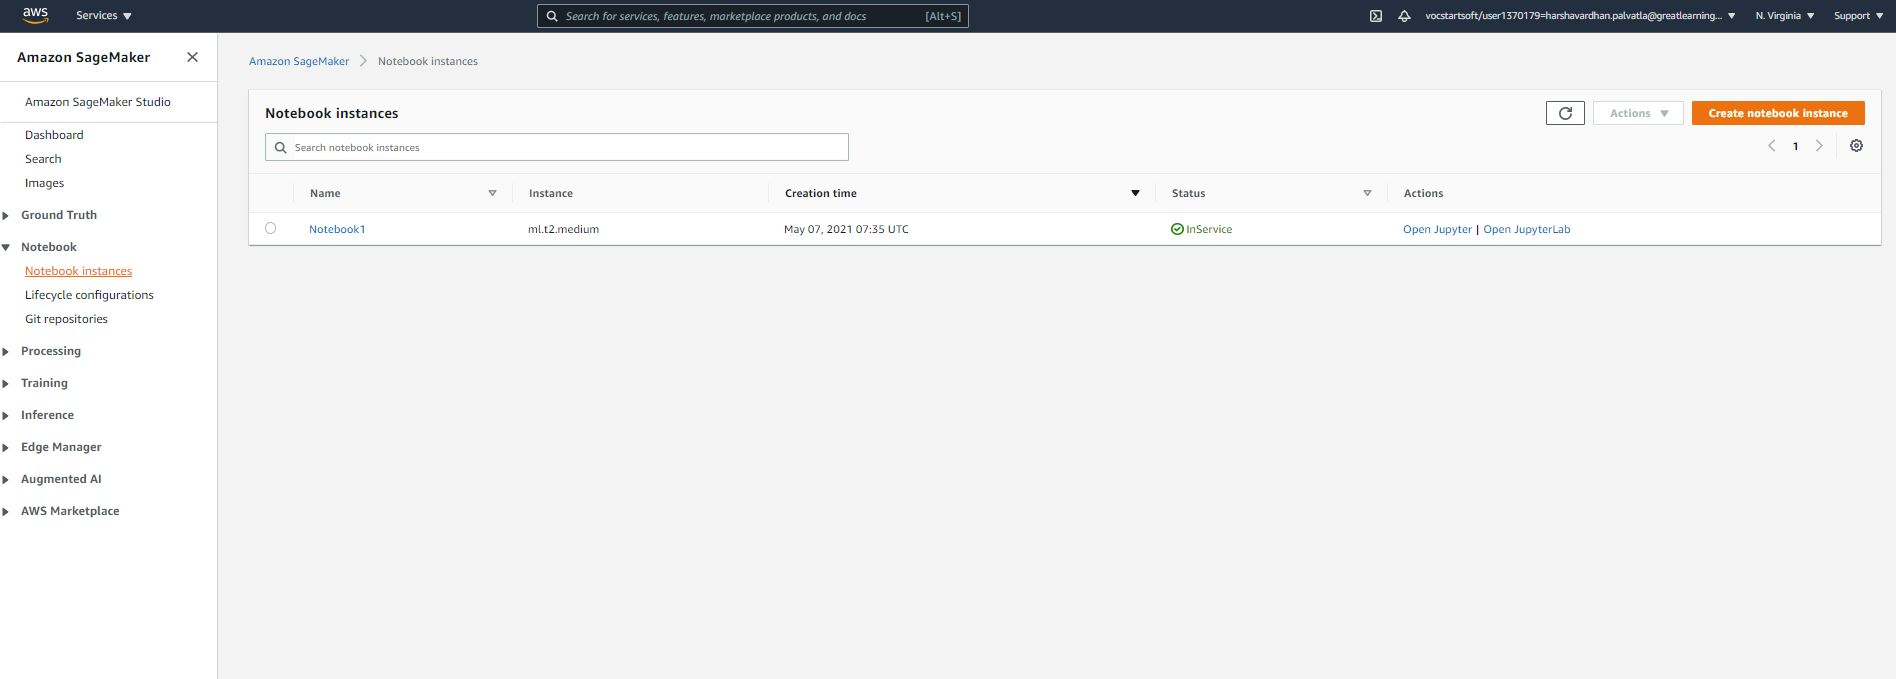

Enter the appropriate name for the notebook instance. Under the IAM role choose the newly created IAM role from the drop down option.

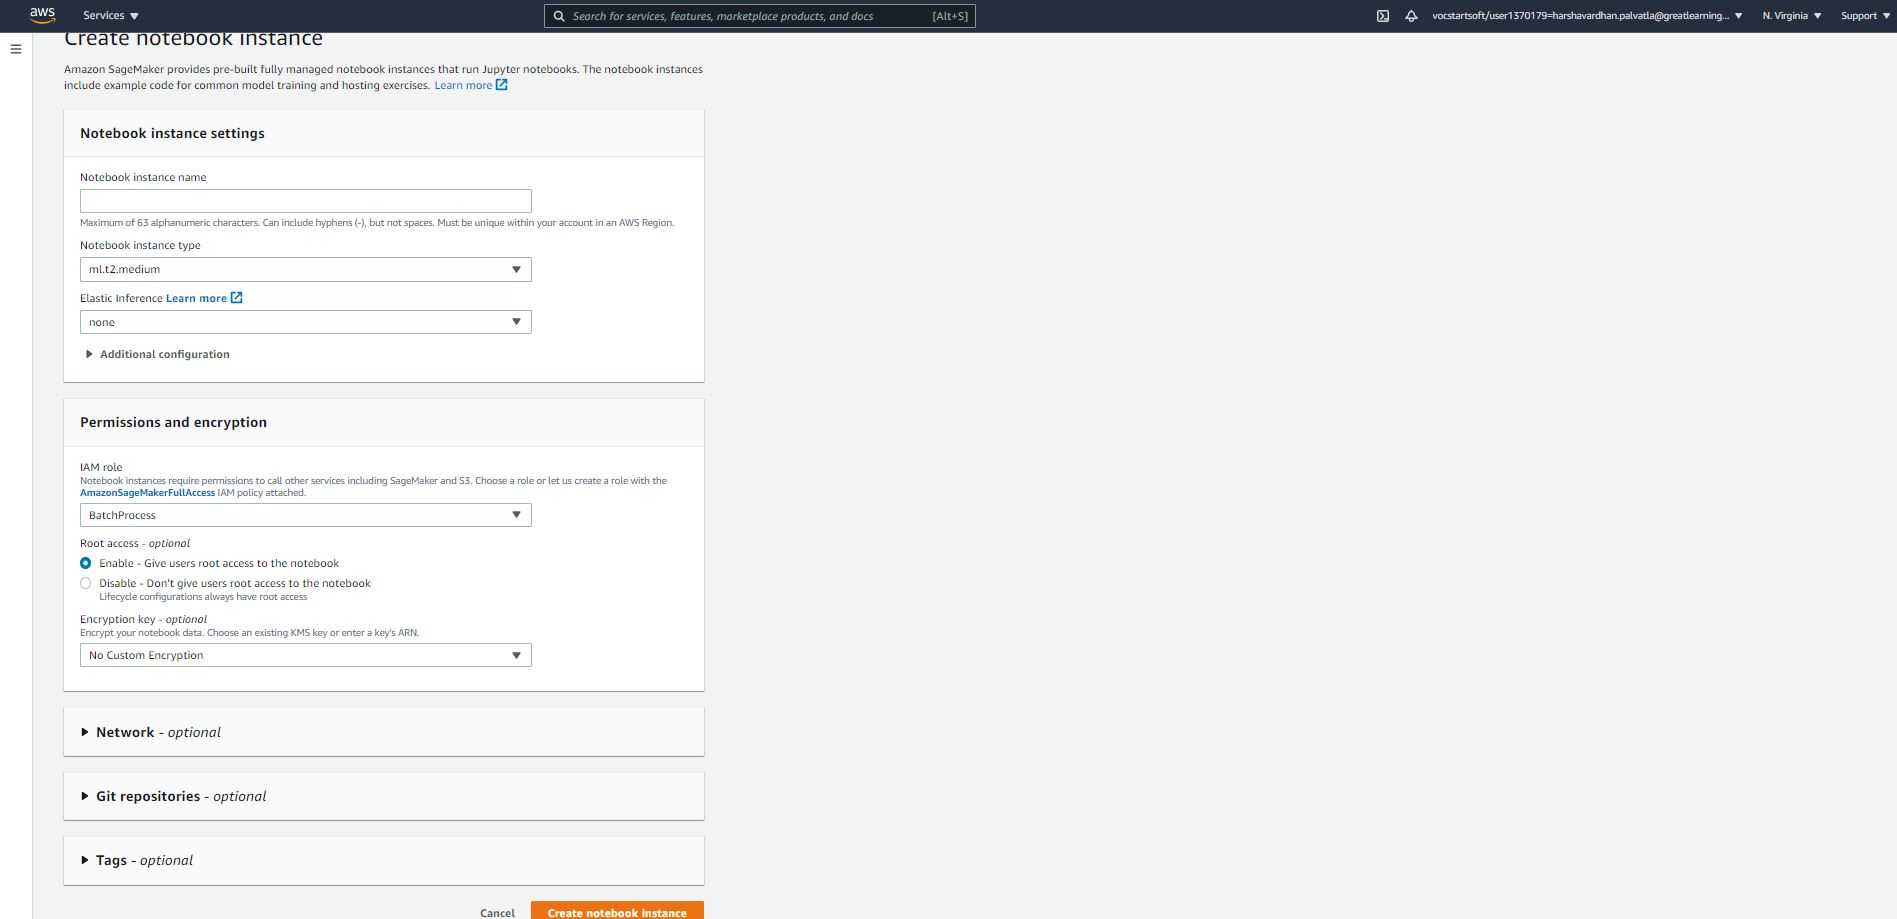


Once done click on Create notebook instance. It will take 2-3 minutes to up the server and status will become `InService`. 

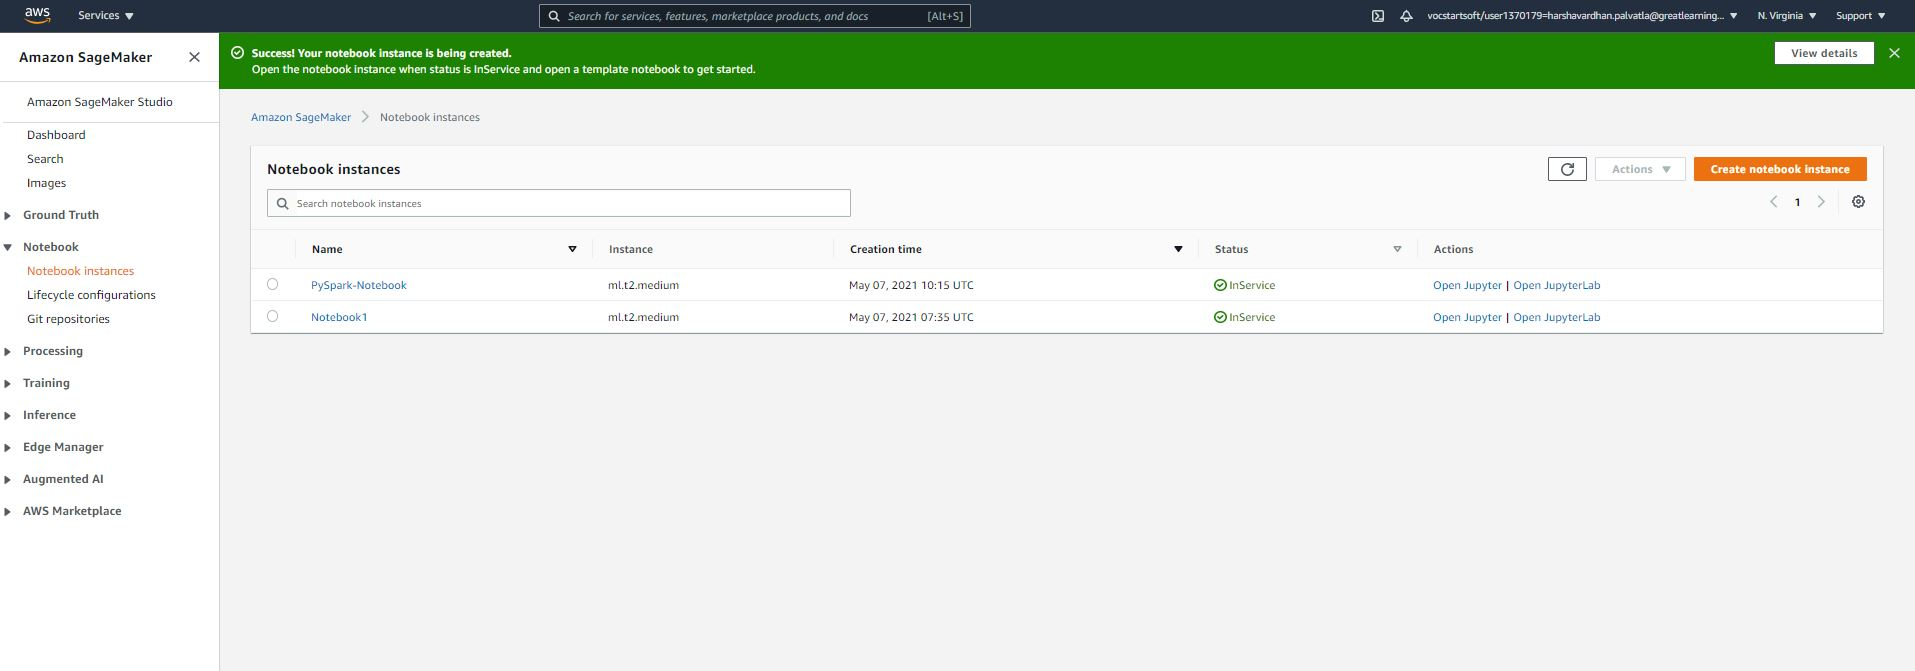

Click on open jupyter option available for that particular instance. This will open a new window where we will be creating and uploading the data for our task.  

Click on New to create the notebook. After clicking on `New`, choose `conda_python3`. 

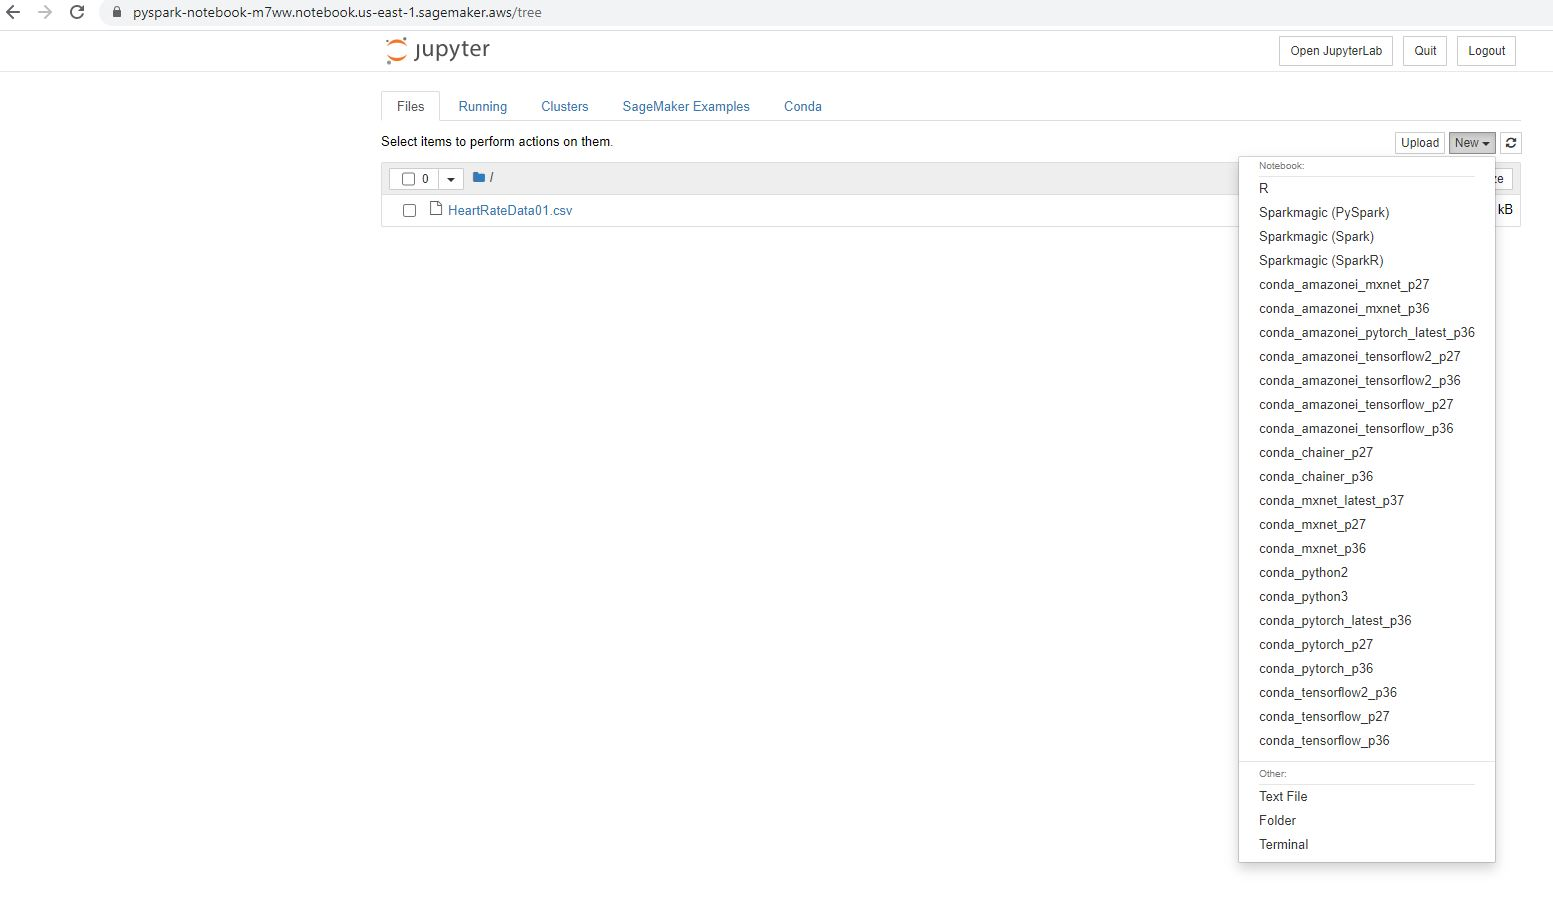

After clicking it a new window will open with the chosen kernel. 

# <font color='blue'> HeartRate Data example : Problem Statement </font>

In this problem statement we are going to simulate data of heart rate readings for a week. 

Created data will have per minute information of heart rate readings. Data will be then used to create the aggregated information as mentioned below: 

* Create aggregated data by combining per minute data into 15 minute interval data. 
* Calculate the moving average of heart rate reading for every 15 minute. 



# <font color='blue'> Sample data creation </font>

In this section we are going to use a simple script which can be used to create the csv files for the heartrate readings. 

This script will create one csv file which will have per minute heart arte readngs for one week.



In [ ]:
import datetime
import csv
import random


def datetime_range(start, end, delta):
    current = start
    with open('HeartRateData01.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        count = 1
        writer.writerow(["SerialNo", "CurrentTime", "CurrentTS", "SubjectId", "HeartRate"])
        while current < end:
            value = int(random.normalvariate(85,12))
            yield current
            currentTS = current.timestamp()
            writer.writerow([count, current, currentTS, "S1098", value])
            current += delta
            count += 1

dts = [dt.strftime('%Y-%m-%d T%H:%M:%S Z') for dt in 
       datetime_range(datetime.datetime(2019, 9, 1, 0, 0), datetime.datetime(2019, 9, 8, 0, 0), 
       datetime.timedelta(seconds=60))]


This cell is generating the `HeartRate` data for our task. Data generated from this script will be inserted in a csv file named as `HeartRateData01.csv`.

# <font color='blue'> HeartRate Data example : Solution </font>

First, we import the necessary modules and create the SparkSession with the SageMaker-Spark dependencies attached.

We will manipulate data through Spark using a SparkSession, and then use the SageMaker Spark library to interact with the data created in the previous step. 


In [ ]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github to learn how to connect to EMR from a notebook instance
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()

spark    

The above cell will just give the details of the Spark Session as shown in the image-

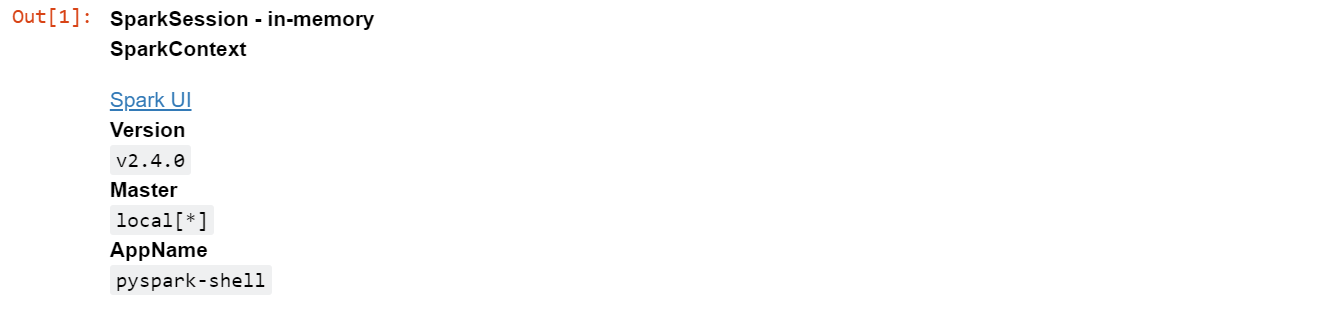

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import window

Above cell will import `functions` and `Window` and `window` methods from pyspark.sql module for our task. 


In [ ]:
#This cell will give error if executed alone
data = spark.read.csv("HeartRateData01.csv", header="true", inferSchema="true")
data.cache() # Cache data for faster reuse
data = data.dropna() # drop rows with missing values
data.printSchema()

In the above cell uploaded csv file will be treated, cleansed and any empty row will be ropped from the dataframe. 

You can also view the Schema of the dataframe as shown in the image-

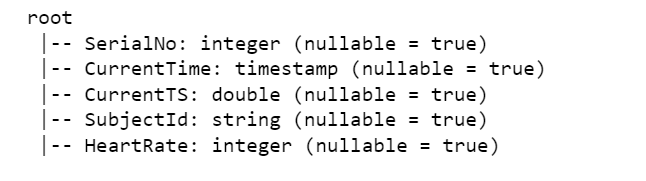

In [ ]:
#This cell will give error if executed alone
data.show(10)

The above cell will display the details of first 10 records as shown in the image-

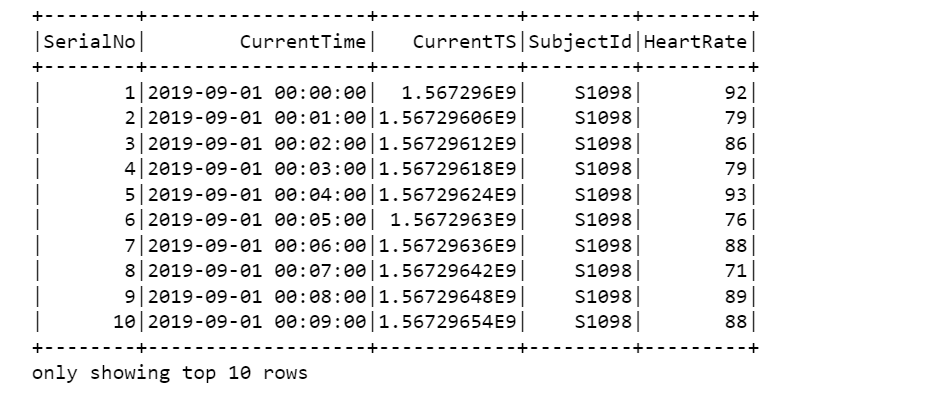

In [ ]:
#This cell will give error if executed alone
w = Window.partitionBy('SubjectId').orderBy("CurrentTS").rangeBetween(-60*15, 0)
RollingAvgData = data.withColumn('RollingAverageHeartRate', F.avg('HeartRate').over(w))
RollingAvgData.show(20)
print(type(RollingAvgData))

This cell will calculate and display the rolling average for 15 minute interval as shown in the image-

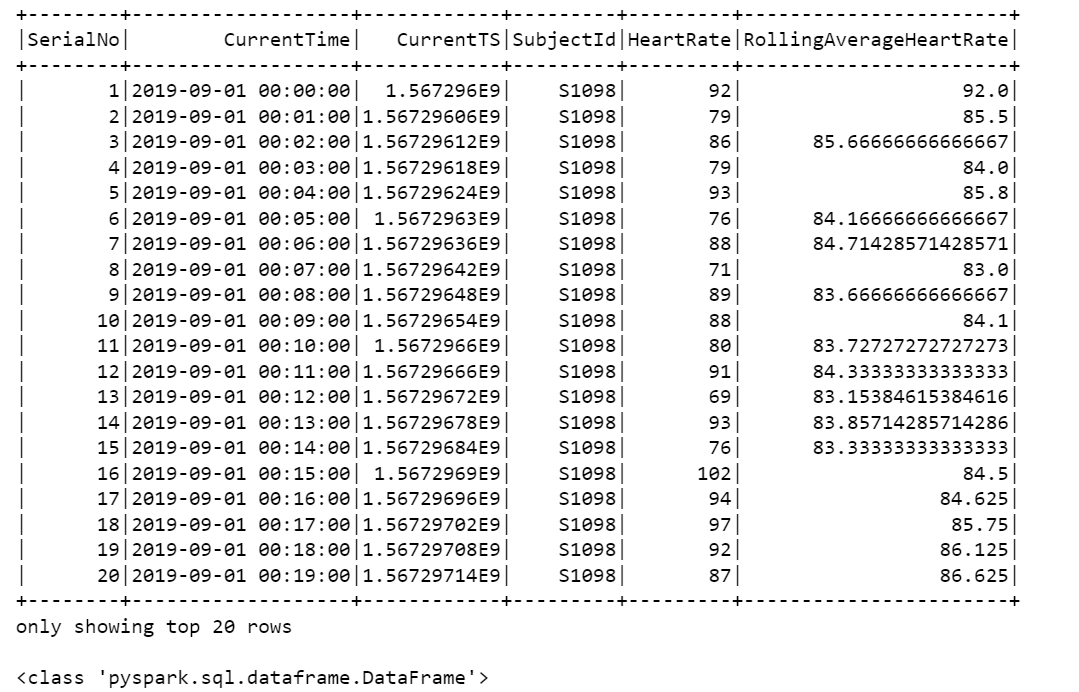

This means that for every upcoming minute, avearge HeartRate will keep on updating. 

What moving average means here: 

* With every upcoming minute average value will keep on getting updated. 
* Once it reaches the 15th Minute, average calculation will start considering the last 15 minutes, i.e. for 16th minute average will be calculated from (1-15) minute. 


In [ ]:
pdf =( 
    RollingAvgData.select(
        "CurrentTime",
        "HeartRate",
        "RollingAverageHeartRate",
    )
    .orderBy("CurrentTime")
    .toPandas()
)


To plot the graph of the dataframe created in the previous step we will be using pandas-bokeh. 

Pandas Bokeh provides a Bokeh plotting backend for Pandas and GeoPandas, similar to the already existing Visualization feature of Pandas. 


Install the pandas-boken using pip command-

In [ ]:
pip install pandas-bokeh # https://pypi.org/project/pandas-bokeh/

In [ ]:
#This cell will give error if executed alone
import pandas_bokeh
pandas_bokeh.output_notebook()
pdf.plot_bokeh.line(x="CurrentTime", y="RollingAverageHeartRate")

After executing the above command on notebook Bokeh JS will plot the line graph as shown in the image-

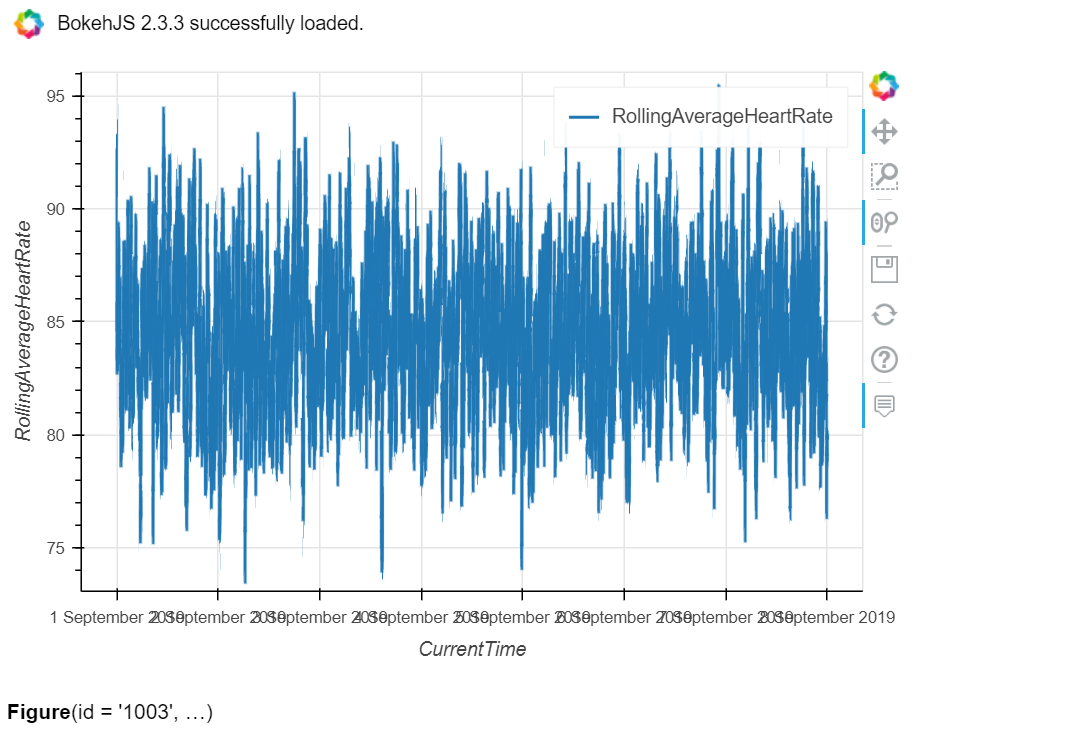

In [ ]:
#This cell will give error if executed alone
AverageHeartRate =  data.groupBy("SubjectId", "CurrentTime", window("CurrentTime", "15 minutes")).avg("HeartRate")
AverageHeartRate.select(AverageHeartRate.window.start.cast("string").alias("StartInterval"), AverageHeartRate.window.end.cast("string").alias("EndInterval"), "avg(HeartRate)").collect()
AverageHeartRate.take(10)

In this cell we are aggregatig the data for 15 minute interval to calculate the average. 

It means that every row in newly created dataframe has aggregated Average HeartRate for that interval as shown in the image-

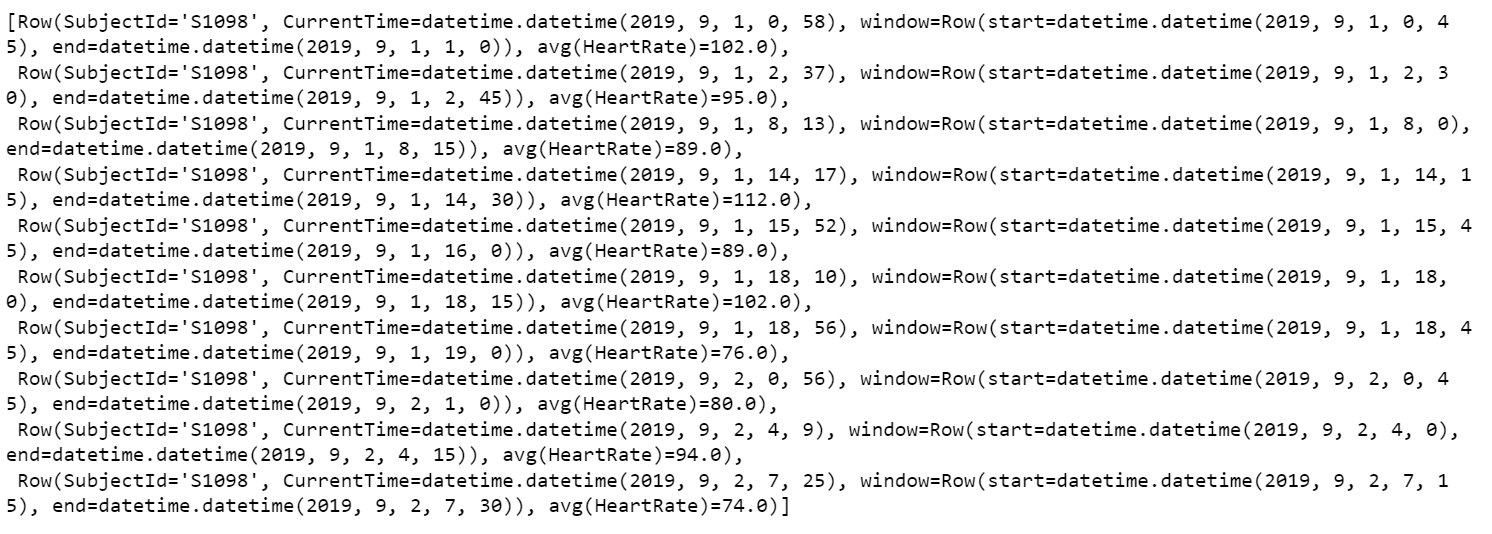


In [ ]:
pdf =( 
    AverageHeartRate.select(
        "CurrentTime",
        "avg(HeartRate)",
    )
    .orderBy("CurrentTime")
    .toPandas()
)

In [ ]:
#This cell will give error if executed alone
import pandas_bokeh
pandas_bokeh.output_notebook()
pdf.plot_bokeh.line(x="CurrentTime", y="avg(HeartRate)")

After executing the above command on notebook Bokeh JS will plot the line graph as shown in the image-

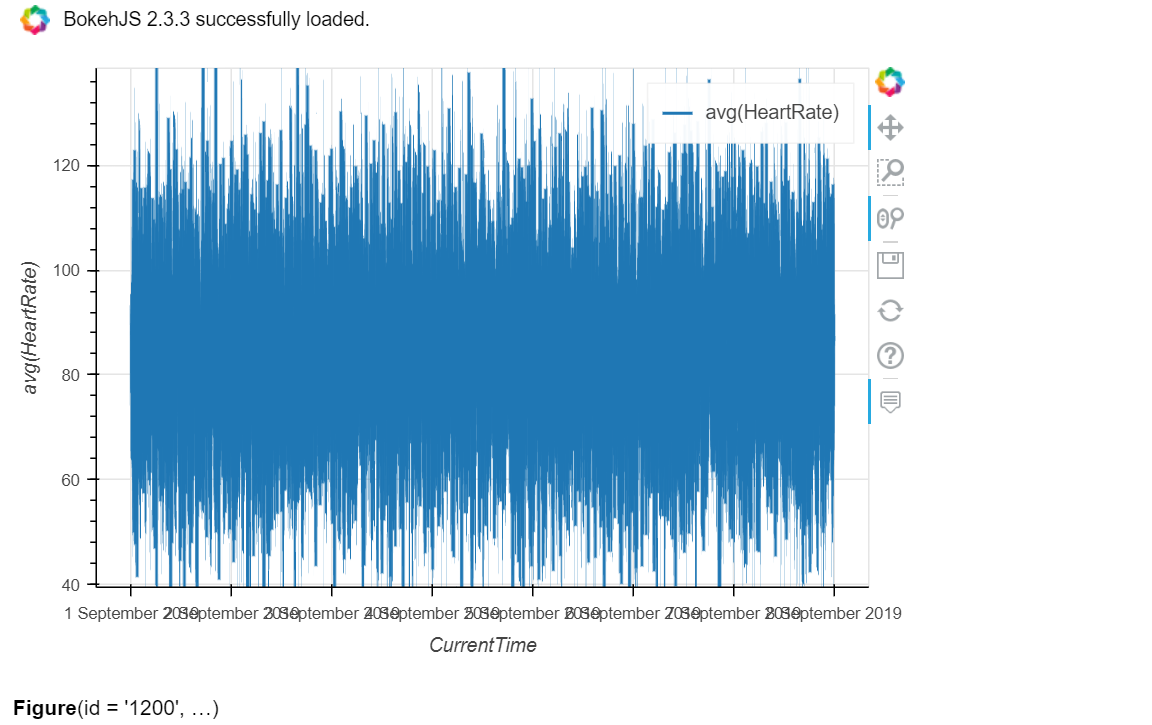